In [1]:
import os
import pandas as pd
import re
from datetime import datetime, timedelta
import calendar
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.layers import *
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **데이터 전처리**

In [17]:
df = pd.read_csv("/content/drive/MyDrive/code/lstm/eco_merged_f.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Change,news_prob_scaled,jongto_prob_scaled,pax_prob_scaled
0,2023-02-01,123500,129500,123500,128400,569539,0.045603,0.720895,0.588008,0.500000
1,2023-02-02,130500,132000,129400,131000,451433,0.020249,0.719629,0.592710,0.500000
2,2023-02-03,130800,142200,129100,137600,1194656,0.050382,0.744021,0.582911,0.500000
3,2023-02-06,138500,149000,138200,146200,1350414,0.062500,0.709026,0.624390,0.500000
4,2023-02-07,147200,178100,147000,165900,3892423,0.134747,0.716227,0.557894,0.268041


In [18]:
df.loc[df['news_prob_scaled'] == 0, 'news_prob_scaled'] = 0.5
df.loc[df['jongto_prob_scaled'] == 0, 'jongto_prob_scaled'] = 0.5
df.loc[df['pax_prob_scaled'] == 0, 'pax_prob_scaled'] = 0.5

In [27]:
df = df.drop(["Date"],axis = 1)
y = df["Close"]
x = df.drop(["Close",'pax_prob_scaled'],axis=1)

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, shuffle=False)

In [29]:
train = pd.concat([x_train,y_train], axis=1)
test = pd.concat([x_test,y_test], axis=1)

In [22]:
test

,Date,Open,High,Low,Volume,Change,news_prob_scaled,jongto_prob_scaled,Close
99,2023-06-27,756000,760000,712000,812930,-0.030223,0.725767,0.597457,738000
100,2023-06-28,747000,752000,699000,648809,-0.051491,0.738301,0.602509,700000
101,2023-06-29,705000,735000,696000,625782,0.020000,0.713726,0.594480,714000
102,2023-06-30,726000,760000,715000,668650,0.056022,0.750419,0.613935,754000
103,2023-07-03,772000,919000,769000,2953165,0.204244,0.743411,0.602574,908000
104,2023-07-04,917000,934000,845000,1878427,-0.024229,0.716428,0.590555,886000
105,2023-07-05,894000,958000,883000,1640065,0.064334,0.713081,0.598438,943000
106,2023-07-06,946000,982000,924000,1198792,-0.002121,0.732397,0.598470,941000
107,2023-07-07,940000,980000,937000,870911,0.041445,0.746974,0.601069,980000
108,2023-07-10,994000,1015000,941000,1105995,-0.015306,0.734669,0.594325,965000


In [16]:
test.head()

,Open,High,Low,Volume,Change,jongto_prob_scaled,pax_prob_scaled,Close
99,756000,760000,712000,812930,-0.030223,0.597457,0.475165,738000
100,747000,752000,699000,648809,-0.051491,0.602509,0.500000,700000
101,705000,735000,696000,625782,0.020000,0.594480,0.500000,714000
102,726000,760000,715000,668650,0.056022,0.613935,0.278057,754000
103,772000,919000,769000,2953165,0.204244,0.602574,0.281153,908000


In [30]:
sc = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

train[scale_cols] = sc.fit_transform(train[scale_cols])
test[scale_cols] = sc.transform(test[scale_cols])

In [31]:
# many2many -> outpu_window size = 1로 함수 수정
def windowDataset(df, window_size, batch_size, shuffle) :
    x = df.drop("Close",axis=1)
    y = df["Close"]
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, stride = 1, shift = 1, drop_remainder = False)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))

    ds_y = tf.data.Dataset.from_tensor_slices([y[i:i+1].values for i in range(window_size, len(y)-1)])

    data = tf.data.Dataset.zip((ds_x,ds_y))

    if shuffle :
        data = data.shuffle(10)

    return data.batch(batch_size).prefetch(1)

In [68]:
WINDOW_SIZE=3
BATCH_SIZE=1
ratio = int(len(train) * 0.7)

train_data = windowDataset(train[:ratio], WINDOW_SIZE, BATCH_SIZE, shuffle= True)
val_data = windowDataset(train[ratio:], WINDOW_SIZE, BATCH_SIZE, shuffle = False)
test_data = windowDataset(test, WINDOW_SIZE, BATCH_SIZE, shuffle = False)

In [33]:
for data in train_data.take(1):
    print(f'학습 데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'학습 데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

학습 데이터셋(X) 구성(batch_size, window_size, feature갯수): (1, 3, 7)
학습 데이터셋(Y) 구성(batch_size, window_size, feature갯수): (1, 1)


In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [70]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[None,7]),
    # LSTM,
    #Dropout(0.2),
    LSTM(32, activation='relu',return_sequences=True),
    LSTM(16, activation='relu',return_sequences=False),
    Dense(16, activation="relu"),
    Dense(1),
])

In [71]:
from keras import metrics
loss = Huber()
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [72]:
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

In [73]:
#모델 훈련하기
epoch = 100
hist = model.fit(train_data,
                   validation_data = val_data,
                   epochs=epoch,
                   callbacks=[checkpoint, earlystopping])

Epoch 1/100
     60/Unknown - 4s 8ms/step - loss: 0.1263 - mse: 0.2527
Epoch 1: val_loss improved from inf to 0.27541, saving model to tmp/ckeckpointer.ckpt
65/65 [==============================] - 5s 22ms/step - loss: 0.1364 - mse: 0.2727 - val_loss: 0.2754 - val_mse: 0.5508
Epoch 2/100
61/65 [===========================>..] - ETA: 0s - loss: 0.1068 - mse: 0.2137
Epoch 2: val_loss improved from 0.27541 to 0.23057, saving model to tmp/ckeckpointer.ckpt
65/65 [==============================] - 1s 11ms/step - loss: 0.1124 - mse: 0.2247 - val_loss: 0.2306 - val_mse: 0.4611
Epoch 3/100
64/65 [============================>.] - ETA: 0s - loss: 0.0834 - mse: 0.1669
Epoch 3: val_loss improved from 0.23057 to 0.16916, saving model to tmp/ckeckpointer.ckpt
65/65 [==============================] - 1s 11ms/step - loss: 0.0842 - mse: 0.1683 - val_loss: 0.1692 - val_mse: 0.3383
Epoch 4/100
57/65 [=========================>....] - ETA: 0s - loss: 0.0445 - mse: 0.0890
Epoch 4: val_loss improved from 0

In [74]:
model.load_weights(filename)

In [75]:
pred = model.predict(test_data)

21/21 [==============================] - 1s 5ms/step


In [63]:
pred.shape

(21, 1)

In [76]:
pred

array([[0.8899806 ],
       [0.8772732 ],
       [0.89855456],
       [0.9934357 ],
       [1.1128016 ],
       [1.1811905 ],
       [1.195814  ],
       [1.2408954 ],
       [1.2508453 ],
       [1.2794071 ],
       [1.2492381 ],
       [1.2276752 ],
       [1.2211379 ],
       [1.2917525 ],
       [1.3710374 ],
       [1.4534098 ],
       [1.487778  ],
       [1.4944147 ],
       [1.576521  ],
       [1.7586051 ],
       [1.9087113 ]], dtype=float32)

In [77]:
tmp = test[2:].reset_index(drop=True)

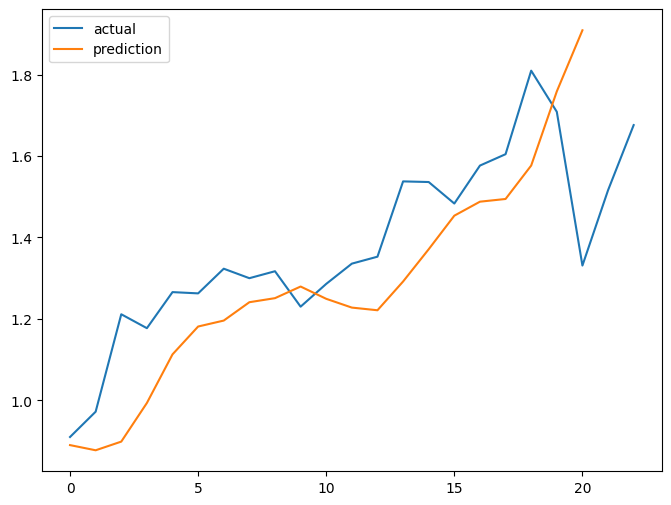

In [78]:
plt.figure(figsize=(8, 6))
plt.plot(tmp["Close"], label='actual')
plt.plot(pred[:], label='prediction')
plt.legend()
plt.show()
#plt.savefig('/content/drive/MyDrive/code/lstm/팍스_종토_w5_pred.png')

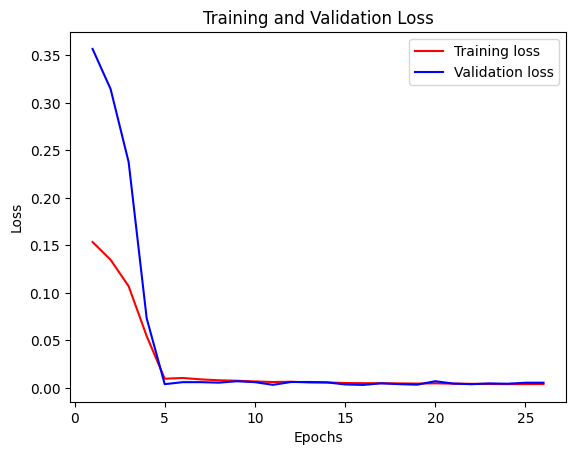

In [55]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
#plt.savefig('/content/drive/MyDrive/code/lstm/팍스_종토_w5_test0.025.png')

In [79]:
score = model.evaluate(test_data)
score

21/21 [==============================] - 0s 4ms/step - loss: 0.0240 - mse: 0.0480


[0.02399800531566143, 0.04799601063132286]